**Purpose: Session 6 assignment is to try to achieve the following:**
- Reduce the parameters
- Use any or all the techniques about CNN layers, loss functions etc.,
- Achieve 99.3% accuracy

#### Install and import libraries

In [1]:
!pip install torch
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**CELL1**

In [4]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# use cuda if available else cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


#### Data related steps:
- Download MNIST data
- Define train and test transforms to create data loaders**

#### CELL2 - Scripts

In [6]:
# # set up train and test loaders
torch.manual_seed(1)

# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [5]:
# Initialize data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

**CELL3**

In [7]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))
  

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

def plot_metrics(loss_train, accuracies_train, loss_test, accuracies_test):
    """
    Plot metrics
    :param loss_train: calculated train losses
    :param accuracies_train: accuracies on training
    :param loss_test: calculated test losses
    :param accuracies_test: accuracies on predicting on test data
    :return: None
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(loss_train)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(accuracies_train)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(loss_test)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(accuracies_test)
    axs[1, 1].set_title("Test Accuracy")
    fig.show()


#### Model - 1:
Using a batch size = 512, learning rate = 0.01
- with 4 convolutional layers, and 2 fully connected layers
- log_softmax function to compute the output and gradient correctly
- train accuracy of 99.29% and test accuracy of 99.38% achieved

In [7]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        # self.fc1 = nn.Linear(2048, 100)
        # self.fc1 = nn.Linear(1024, 100)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)
        # self.fc3 = nn.Linear(10, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096) # 4*4*256 = 4096
        # x = x.view(-1, 2048) # 4*4*128 = 2048
        # x = x.view(-1, 1024) # 4*4*64 = 1024
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [8]:
# Display model - 1 summary
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [11]:
# Train and test the model for epochs = 20, lr=0.01
model = Net().to(device)
lrate = 0.01
num_epochs = 20
step_size=15
print(f"Training parameters for Model - 1: \n learning parameter of {lrate}, batch_size:{batch_size}, number of epochs={num_epochs}, step size: {step_size}\n")
optimizer = optim.SGD(model.parameters(), lr=lrate, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Training parameters for Model - 1: 
 learning parameter of 0.01, batch_size:512, number of epochs=20, step size: 15

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3788 Batch_id=117 Accuracy=43.95: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Test set: Average loss: 0.2576, Accuracy: 9231/10000 (92.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1448 Batch_id=117 Accuracy=93.51: 100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Test set: Average loss: 0.0918, Accuracy: 9708/10000 (97.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0383 Batch_id=117 Accuracy=96.35: 100%|██████████| 118/118 [00:28<00:00,  4.19it/s]


Test set: Average loss: 0.0561, Accuracy: 9832/10000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0463 Batch_id=117 Accuracy=97.22: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s]


Test set: Average loss: 0.0447, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0282 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Test set: Average loss: 0.0415, Accuracy: 9868/10000 (98.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1254 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:24<00:00,  4.82it/s]


Test set: Average loss: 0.0408, Accuracy: 9875/10000 (98.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0429 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:27<00:00,  4.35it/s]


Test set: Average loss: 0.0321, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0708 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:30<00:00,  3.88it/s]


Test set: Average loss: 0.0320, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0156 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:31<00:00,  3.77it/s]


Test set: Average loss: 0.0317, Accuracy: 9890/10000 (98.90%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0335 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Test set: Average loss: 0.0290, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0486 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:24<00:00,  4.72it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0069 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s]


Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0204 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s]


Test set: Average loss: 0.0288, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0250 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0232 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


Test set: Average loss: 0.0232, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0188 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:25<00:00,  4.54it/s]


Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0796 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0386 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0937 Batch_id=117 Accuracy=99.24: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0069 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:27<00:00,  4.37it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-03.


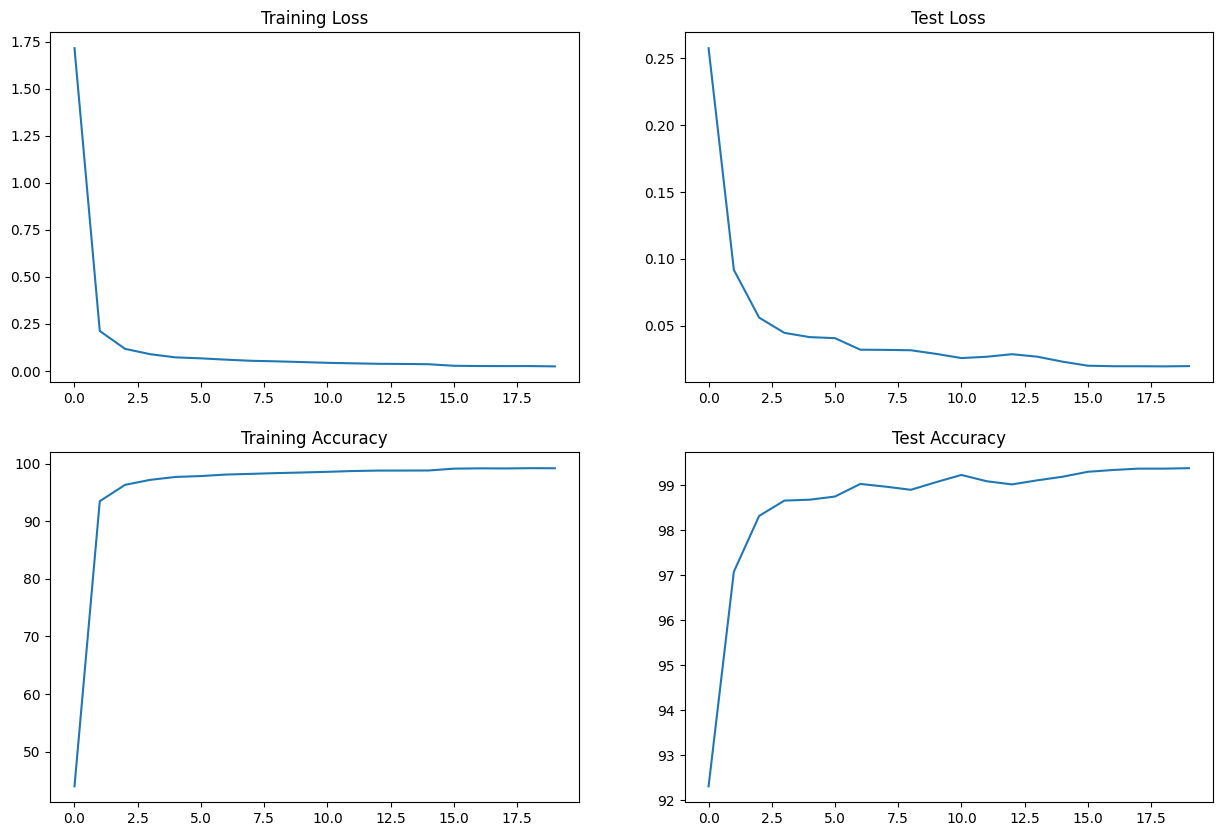

In [14]:
# plot train and test accuracies and losses # Data to plot accuracy and loss graphs
plot_metrics(train_losses, train_acc, test_losses, test_acc)

#### Model - 2: 
Using a batch size = 512, learning rate = 0.1
- Here I have tried to reduce the total number of parameters (ended up with 56K parameters)
- Reducing with just one dropout layer with dropout probability as 0.25 and will reduced output and input channels yielded very low accuracy
- Next I added another dropout layer with different dropout probability as per what I read online.
- log_softmax function to compute the output and gradient correctly
- Even though I couldn't reduce to ~20K parameters, I certainly reduced the number of parameters and got an accuracy on training of 98.35% and testing accuracy of 99.29%

**NOTE:** 
- sometimes with COLAB it gives exception but still proceeds with execution. So please restart runtime and rerun the cells CELL1, CELL2-Scripts, CELL3 and then run cells below...
- some commented code is there to show that I have tried several ways of reducing the parameters etc.,

In [8]:
class Net2(nn.Module):
    #This defines the structure of the NN.
    def __init__(self, input_shape=(1,28,28)):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        # self.conv4 = nn.Conv2d(32, 64, kernel_size=3)

        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        
        # added a dropout rate with dropout probability of 0.25
        self.dropout = nn.Dropout(0.25)
                
        # self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        # self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2,2)
        
        n_size = self._get_conv_output(input_shape)
        # self.fc1 = nn.Linear(2048, 120)          # (16 * 5 * 5, 120)  # 5x5 image dimension
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

        # # 1
        # self.fc1 = nn.Linear(128, 120)          # (16 * 5 * 5, 120)  # 5x5 image dimension
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

        # # 2
        # self.fc1 = nn.Linear(128, 60)
        # self.fc2 = nn.Linear(60, 42)
        # self.fc3 = nn.Linear(42, 10)

        # # 3
        # self.fc1 = nn.Linear(128, 30)
        # self.fc2 = nn.Linear(30, 21)
        # self.fc3 = nn.Linear(21, 10)
        # # 3
        # self.fc1 = nn.Linear(256, 30)
        # self.fc2 = nn.Linear(30, 21)
        # self.fc3 = nn.Linear(21, 10)
        # # 3
        # self.fc1 = nn.Linear(512, 30)
        # self.fc2 = nn.Linear(30, 21)
        # self.fc3 = nn.Linear(21, 10)
        # 3
        self.dropout = nn.Dropout(0.40)
        self.fc1 = nn.Linear(1024, 30)
        self.fc2 = nn.Linear(30, 21)
        self.fc3 = nn.Linear(21, 10)
        
        # # 4 
        # self.fc1 = nn.Linear(128, 15)
        # self.fc2 = nn.Linear(15, 15)
        # self.fc3 = nn.Linear(15, 5)

        # # 5 
        # self.fc1 = nn.Linear(128, 4)
        # self.fc2 = nn.Linear(4, 3)
        # self.fc3 = nn.Linear(3, 2)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
        # print(f"shape of x: {x.shape}")
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
        # print(f"shape of x: {x.shape}")
        x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
        x = self.dropout(x)
        # print(f"shape of x: {x.shape}")
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
        # x = self.dropout(x)
        # print(f"shape of x: {x.shape}")
        # print(f"shape of x: {x.shape}")
        # x = x.view(-1, 4096) # 4*4*256 = 4096
        # x = x.view(-1, 2048) # 4*4*128 = 2048
        # x = x.view(-1, 1024) # 4*4*64 = 1024
        # x = x.view(-1, 2048)   # int(x.nelement() / x.shape[0]))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = x.view(-1, 128) 

        # 1 & 2  
        x = self.dropout(x)
        x = x.view(-1, 1024) 
        # x = x.view(-1, 256) 
        # x = x.view(-1, 512) 
        # x = x.view(-1, 128)
        # print(f"shape of x: {x.shape}")        
        x = F.relu(self.fc1(x))
        # print(f"shape of x: {x.shape}")
        x = F.relu(self.fc2(x))        
        x = self.fc3(x)
        # print(f"shape of x: {x.shape}")
        return F.log_softmax(x, dim=1)

In [9]:
# Initialize data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 1, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader

In [12]:
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 24, 24]           1,168
            Conv2d-3           [-1, 32, 10, 10]           4,640
           Dropout-4           [-1, 32, 10, 10]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
           Dropout-6             [-1, 64, 4, 4]               0
            Linear-7                   [-1, 30]          30,750
            Linear-8                   [-1, 21]             651
            Linear-9                   [-1, 10]             220
Total params: 56,005
Trainable params: 56,005
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.21
Estimated Total Size (MB): 0.42
---------------------------------------------

In [14]:
model2 = Net2().to(device)
lrate2 = 0.1
num_epochs = 20
step_size=25
print(f"Training parameters for Model - 2: \n learning parameter of {lrate2}, batch_size:{batch_size}, number of epochs={num_epochs}, step size: {step_size}\n")
optimizer = optim.SGD(model2.parameters(), lr=lrate2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1, verbose=True)
# using nll_loss
criterion = F.nll_loss

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model2, device, train_loader, optimizer, criterion)
  test(model2, device, test_loader, criterion)
  scheduler.step()

Training parameters for Model - 2: 
 learning parameter of 0.1, batch_size:512, number of epochs=20, step size: 25

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.2632 Batch_id=117 Accuracy=49.06: 100%|██████████| 118/118 [00:26<00:00,  4.46it/s]


Test set: Average loss: 0.2521, Accuracy: 9319/10000 (93.19%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=0.2719 Batch_id=117 Accuracy=92.59: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Test set: Average loss: 0.0924, Accuracy: 9720/10000 (97.20%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=0.0855 Batch_id=117 Accuracy=95.64: 100%|██████████| 118/118 [00:26<00:00,  4.37it/s]


Test set: Average loss: 0.0448, Accuracy: 9865/10000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=0.0611 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Test set: Average loss: 0.0379, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=0.1229 Batch_id=117 Accuracy=96.97: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Test set: Average loss: 0.0375, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=0.0781 Batch_id=117 Accuracy=97.34: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Test set: Average loss: 0.0376, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7


Train: Loss=0.0773 Batch_id=117 Accuracy=97.62: 100%|██████████| 118/118 [00:29<00:00,  4.02it/s]


Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8


Train: Loss=0.0622 Batch_id=117 Accuracy=97.60: 100%|██████████| 118/118 [00:27<00:00,  4.32it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9


Train: Loss=0.0475 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:27<00:00,  4.32it/s]


Test set: Average loss: 0.0370, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10


Train: Loss=0.0131 Batch_id=117 Accuracy=97.83: 100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Test set: Average loss: 0.0283, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11


Train: Loss=0.0378 Batch_id=117 Accuracy=97.89: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Test set: Average loss: 0.0419, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12


Train: Loss=0.0732 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Test set: Average loss: 0.0283, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13


Train: Loss=0.0711 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Test set: Average loss: 0.0287, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14


Train: Loss=0.0308 Batch_id=117 Accuracy=98.01: 100%|██████████| 118/118 [00:27<00:00,  4.29it/s]


Test set: Average loss: 0.0292, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15


Train: Loss=0.0556 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 16


Train: Loss=0.0449 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 17


Train: Loss=0.0718 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]


Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 18


Train: Loss=0.0286 Batch_id=117 Accuracy=98.21: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 19


Train: Loss=0.0270 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Test set: Average loss: 0.0276, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 20


Train: Loss=0.0133 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-01.


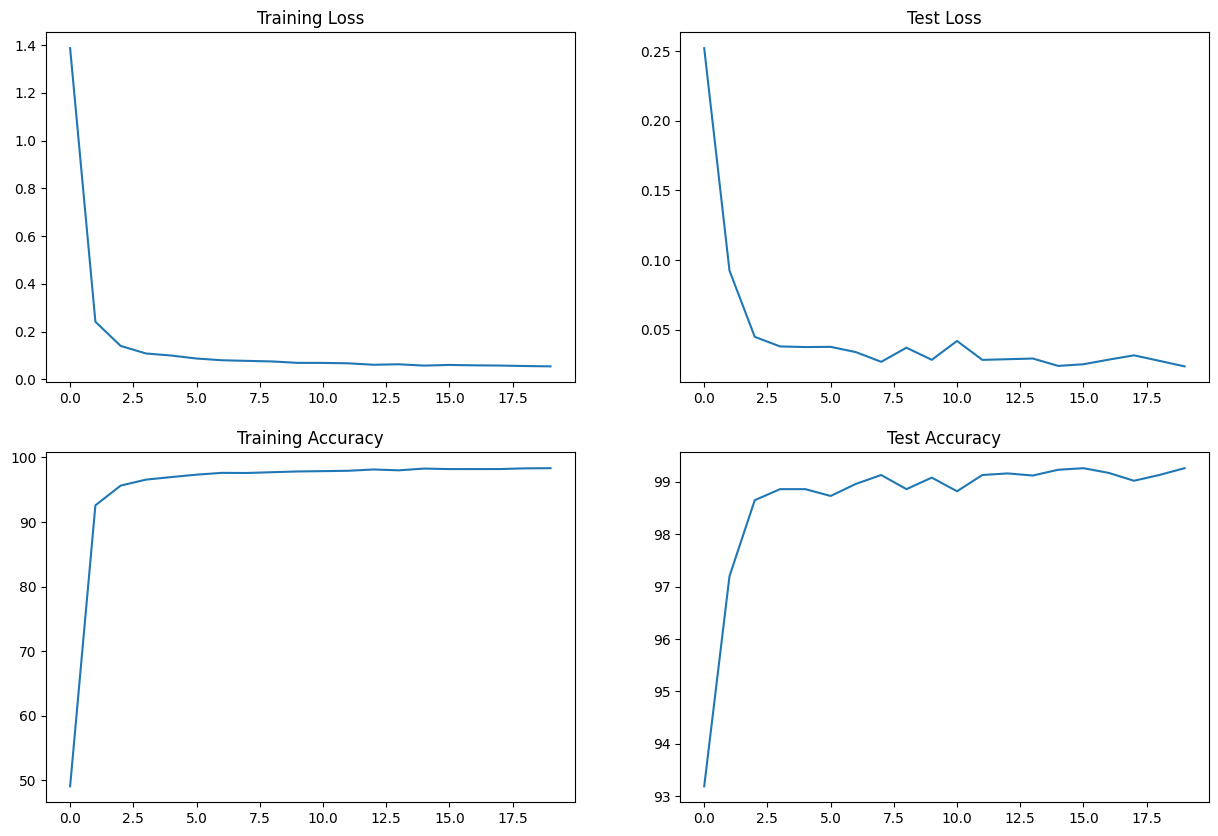

In [15]:
# plot train and test accuracies and losses # Data to plot accuracy and loss graphs
plot_metrics(train_losses, train_acc, test_losses, test_acc)